# Agent-Based Model: Measles Transmission in Schools 

This notebook is designed to demonstrate an agent-based model (ABM) for measles transmission within a controlled setting (school). The aims are to demonstrate:
- **Individual-level heterogeneity**: Each student is a separate agent with unique characteristics 
- **Spatial structure**: Students are organized by grade and classroom 
- **Contact patterns**: Realistic within-classroom and between-classroom mixing
- **Vaccination**: Coverage patterns and clustering effects 
- **Stochastic dynamics**: Randomness in transmission and disease progression 

#### Why an agent-based model for measles in schools? 

ABMs excel at capturing phenomena that compartmental models struggle with:
- **Clustering**: Unvaccinated students often cluster in specific classrooms/communities 
- **Network effects**: Disease spreads through contact networks, not homogenous mixing 
- **Interventions**: Can test targeted strategies (e.g., classroom closures, ring vaccination)
- **Stochasticity**: Small outbreaks can fade out randomly or explode

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from IPython.display import HTML 
import warnings 
warnings.filterwarnings('ignore') 

import sys, os 
sys.path.append(os.path.abspath(os.path.join('..','src')))

from epimodels.measles_ab_model import School, Student, MeaslesParameters, MeaslesABM, DiseaseState
from epimodels.utils.visualizations_measles_abm import (plot_seir_timeseries, plot_classroom_heatmap, 
create_outbreak_animation, compare_scenarios, plot_vaccination_sensitivity, summarize_epidemic_statistics)

# set random seed 
np.random.seed(42)

# display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Model Setup and Basic Simulation

### School strucutre
Elementary school with:
- 6 grades (Grades 1-6)
- 3 classrooms per grade 
- 25 students per classroom
- **Total: 450 students**

In [2]:
# create school
school = School(
    n_grades = 6,
    students_per_classroom = 25, 
    classrooms_per_grade = 3
)

print(f"School created with {school.total_students} students")
print(f"Organization: {school.n_grades} grades x {school.classrooms_per_grade} classrooms x {school.students_per_classroom} students")

School created with 450 students
Organization: 6 grades x 3 classrooms x 25 students


### Measles Parameters

Measles is one of the most contagious diseases known, with R0 typically ranging from 12-18.

Key epidemiological parameters:
- **Latent period**: ~10 days (infected but not yet infectious)
- **Infectious period**: ~8 days
- **Transmission**: Very high, especially in close-contact settings
- **Vaccine efficiency**: ~97% with two doses (MMR vaccine)

In [3]:
# define measles parameters
params = MeaslesParameters(
    beta_within = 0.08,     # high transmission within classroom
    beta_between = 0.005,   # lower transmission between classrooms
    sigma = 0.1,            # 1/10 day latent period
    gamma = 0.125,          # 1/8 day infectious period
    contacts_within = 20,   # many contacts with classmates
    contacts_between = 5,   # fewer contacts with other students
    vaccine_efficacy = 0.97   # MMR vaccine efficacy
)
print("Measles Parameters:")
print(f"  Within-classroom R₀: {params.R0_within:.2f}")
print(f"  Between-classroom R₀: {params.R0_between:.2f}")
print(f"  Effective R₀ (combined): ~{params.R0_within + params.R0_between:.2f}")
print(f"  Latent period: {1/params.sigma:.1f} days")
print(f"  Infectious period: {1/params.gamma:.1f} days")

Measles Parameters:
  Within-classroom R₀: 12.80
  Between-classroom R₀: 0.20
  Effective R₀ (combined): ~13.00
  Latent period: 10.0 days
  Infectious period: 8.0 days


## Baseline Scenario: No Vaccination

Simulate measles spreading through a completely susceptible school population. This represents a "worst case" scenario and helps us understand the natural dynamics of measles transmission. 

In [4]:
# reset school (no vaccination)
school_baseline = School(n_grades=6, students_per_classroom=25, classrooms_per_grade=3)

# introduce 1 infected student in Grade 3
school_baseline.introduce_infection(n_infections=1, target_grade=3)
school_baseline.introduce_infection(n_infections=1, target_grade=3)

# create ABM and run simulation
abm_baseline = MeaslesABM(school_baseline, params)
history_baseline = abm_baseline.run(n_days=120, dt=1.0, record_interval=1)

print("Baseline simulation:")
print(summarize_epidemic_statistics(history_baseline))

Baseline simulation:
                     Metric  Value
0       Initial Susceptible    448
1         Final Susceptible      0
2            Total Infected    444
3           Attack Rate (%)  99.11
4           Peak Infectious     88
5                  Peak Day     83
6            First Case Day    N/A
7             Last Case Day    120
8  Epidemic Duration (days)    N/A


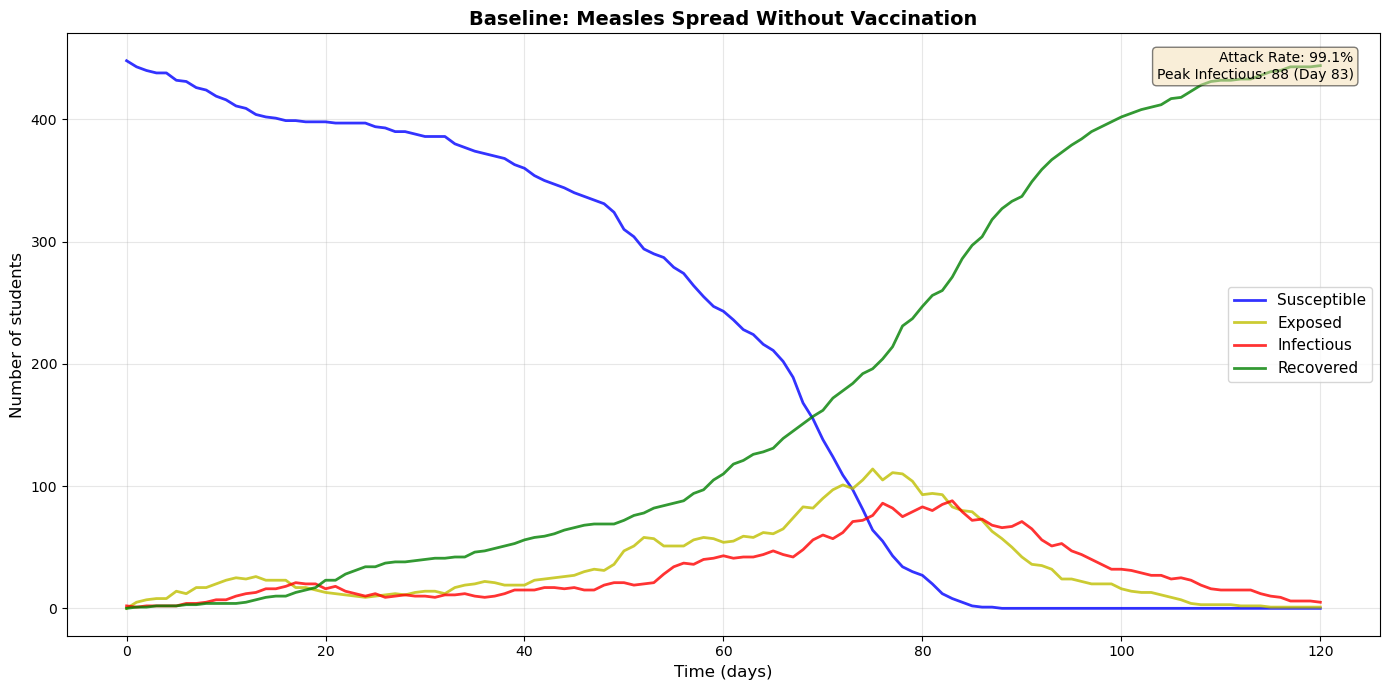

In [5]:
# visualize baseline dynamics
plot_seir_timeseries(
    history_baseline,
    title="Baseline: Measles Spread Without Vaccination",
    figsize=(14,7)
)

### Spatial Visualization: Outbreak Spread by Classroom

A key advantage of ABM is the ability to visualize disease spread through spatial structure. 

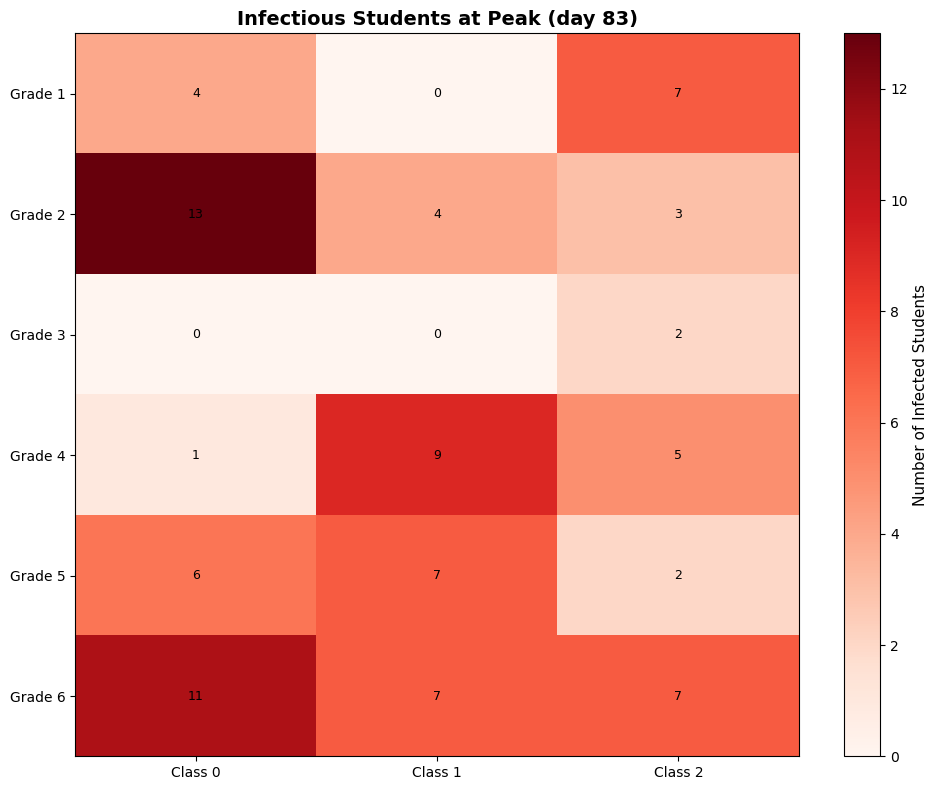

In [6]:
# visualize classroom-level spread at peak
peak_time, peak_infectious = abm_baseline.get_epidemic_peak()
peak_index = [i for i, r in enumerate(history_baseline) if r['time'] == peak_time][0]

plot_classroom_heatmap(
    history_baseline[peak_index]['classroom_data'],
    state = 'I',
    title = f"Infectious Students at Peak (day {peak_time:.0f})"
)